In [1]:
import numpy as np
import pandas as pd
import orca
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import os; os.chdir('../../')
import warnings; warnings.simplefilter('ignore')

import pandana as pdna
from collections import OrderedDict
import pylogit as pl
from pylogit import nested_logit as nl
import math 
import pickle
import dill
import time
import random
import scipy.stats as st
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
    
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim_templates.models import BinaryLogitStep
from urbansim.utils import misc
import urbansim_templates

from scripts import datasources, models, variables, utils

Registering model step 'auto_ownership'
Registering model step 'WLCM_gen_tt'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [2]:
input_file_format = 'csv'
input_data_dir = '/home/data/spring_2019/base/'

formattable_fname_dict = {
    'parcels': 'parcels.{0}',
    'buildings': 'buildings.{0}',
    'jobs': 'jobs.{0}',
    'establishments': 'establishments.{0}',
    'households': 'households.{0}',
    'persons': 'persons.{0}',
    'rentals': 'craigslist.{0}',
    'units': 'units.{0}',
    'mtc_skims': 'mtc_skims.{0}',
    'beam_skims_raw': '30.skims-smart-23April2019-baseline.csv.gz',
    'beam_skims_imputed': 'beam_skims_imputed.{0}',
    # the following nodes and edges .csv's will be phased out and
    # replaced by travel model skims entirely
    'drive_nodes': 'drive_nodes.{0}',
    'drive_edges': 'drive_edges.{0}',
    'drive_access_vars': 'drive_net_vars.{0}',
    'walk_nodes': 'walk_nodes.{0}',
    'walk_edges': 'walk_edges.{0}',
    'walk_access_vars': 'walk_net_vars.{0}',
    'zones': 'zones.{0}',
    'zone_access_vars': 'zones_w_access_vars.{0}',
}

def format_fname_dict(formattable_fname_dict, format='csv'):
    formatted_dict = {
        k: v.format('csv')
        for k, v in formattable_fname_dict.items()}
    return formatted_dict

input_fnames = format_fname_dict(
            formattable_fname_dict, input_file_format)

In [3]:
orca.add_injectable('input_file_format', input_file_format)
orca.add_injectable('input_data_dir', input_data_dir)
orca.add_injectable('input_fnames', input_fnames)
orca.add_injectable('store', None)

In [4]:
orca.run(['initialize_network_small']) 
orca.run(['initialize_network_walk']) 
orca.run(['initialize_imputed_skims']) 
orca.run(['skims_aggregations']) 

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Removed 189769 rows because they contain missing values
Computing hh_10000
Removed 189769 rows because they contain missing values
Computing poor_10000
Removed 53114 rows because they contain missing values
Computing renters_10000
Removed 102597 rows because they contain missing values
Computing avg_income_10000
Removed 189769 rows because they contain missing values
Computing jobs_10000
Computing avg_rent_10000
Computing med_rent_10000
Computing pop_white_10000
Removed 107372 rows because they contain missing values
Computing pop_black_10000
Removed 10541 rows because they contain missing values
Computing pop_asian_10000
Removed 51048 rows because they contain missing values
Computing pop_hisp_10000
Removed 31685 rows because

Computing pop_black_1500_walk
Removed 10541 rows because they contain missing values
Computing pop_asian_1500_walk
Removed 51048 rows because they contain missing values
Computing pop_hisp_1500_walk
Removed 31685 rows because they contain missing values
Computing pop_2500_walk
Removed 189769 rows because they contain missing values
Computing pop_white_2500_walk
Removed 107372 rows because they contain missing values
Computing pop_black_2500_walk
Removed 10541 rows because they contain missing values
Computing pop_asian_2500_walk
Removed 51048 rows because they contain missing values
Computing pop_hisp_2500_walk
Removed 31685 rows because they contain missing values
Computing jobs_500_walk_retail
Computing jobs_1500_walk_retail
Computing jobs_2500_walk_retail
Computing jobs_500_walk_fire
Computing jobs_1500_walk_fire
Computing jobs_2500_walk_fire
Computing jobs_500_walk_tech
Computing jobs_1500_walk_tech
Computing jobs_2500_walk_tech
Computing jobs_500_walk_serv
Computing jobs_1500_walk

In [48]:
# #In case I need to redo this. 
# nodessmall = orca.get_table('nodessmall').to_frame()
# nodeswalk = orca.get_table('nodeswalk').to_frame()
# nodessmall.to_csv('nodessmall.csv')
# nodeswalk.to_csv('nodeswalk.csv')

In [70]:
k12_students = pd.read_csv('/home/juan/ual_model_workspace/spring-2019-models/notebooks-juan/students_with_school_id.csv')
persons = pd.read_csv('/home/data/fall_2018/chts_persons_w_zone_ids.csv')
households = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_HH.csv")
zones = orca.get_table('zones').to_frame()
beam_skims = orca.get_table('beam_skims_imputed').to_frame().reset_index()
schools = orca.get_table('schools').to_frame()

#I have save this tables on disk just for convinience
nodessmall = pd.read_csv('nodessmall.csv').set_index('osmid')
nodeswalk = pd.read_csv('nodeswalk.csv').set_index('osmid')

## Data cleaning

In [137]:
students = k12_students.copy(deep=True)

#Getting the type (public/private) of school for each observation
students = students.merge(schools.loc[:,['type']], how = 'left', left_on = 'school_id', right_index = True)
students['s_type'] = students.type.replace(['public', 'private'], [1,0])

#Filtering correct age 
students = students[students.AGE <= 18]

#Hispanic indicador
students.HISP.replace([2,9,8], [0, np.nan, np.nan], inplace = True)

#Sex indicator 
students.GEND.replace(2,0, inplace = True) # 1 male, 0 female

#Cheking if there is more than one race per person
students['race'] = students.RACE1.notnull().astype(int) + \
                          students.RACE2.notnull().astype(int) + \
                          students.RACE3.notnull().astype(int) + \
                          students.RACE4.notnull().astype(int)


students['race'] = students['race'].replace(2, 6) # Two or more races (6. 2+ races)
students['race'] = np.where(students['race'] == 1, students['RACE1'], students['race'])

students.rename(columns = {'HISP': 'hispanic', 'AGE': 'age', 'GEND': 'sex'}, inplace = True)

###################################
#Merging household characteristics
###################################

#Getting number of children per household, race and age of the head (head assume to be PERNO == 1)
persons['children'] = (persons.AGE < 18).astype(int) # Children indicator
# persons.loc[:,['RACE1', 'RACE2', 'RACE3', 'RACE4', 'O_RACE']]
persons['race_id'] = persons.RACE1.notnull().astype(int) + \
                          persons.RACE2.notnull().astype(int) + \
                          persons.RACE3.notnull().astype(int) + \
                          persons.RACE4.notnull().astype(int)

persons['race_id'] = persons['race_id'].replace(2, 6) # Two or more races (6. 2+ races)
persons['race_id'] = np.where(persons['race_id'] == 1, persons['RACE1'], persons['race_id'])


hh_per_var = persons.loc[:,['SAMPN', 'PERNO', 'children','race_id', 'AGE', 'HISP']].sort_values(['SAMPN', 'PERNO']).groupby('SAMPN').\
             agg({'children': 'sum', 'race_id': 'first', 'AGE': 'first', 'HISP': 'first'})

hh_per_var.rename(columns = {'AGE': 'age_of_head', 'race_id': 'race_head', 'HISP': 'hispanic_head'}, inplace = True)
hh_per_var.hispanic_head.replace(2,0, inplace = True) # 1 is hispanic, 0 itherwise

students = students.merge(hh_per_var, how = 'inner', left_on = 'SAMPN', right_index = True )

#Merging household table
households['recent_mover'] = (households.TEN <= 5).astype(int)

#Naming varaibles as in PUMS varaibles
pums_names = {'HHSIZ': 'persons', 'INCOM': 'income', 'OWN': 'tenure', 'HHVEH': 'cars', 'HHEMP': 'workers' }
households.rename(columns=pums_names, inplace = True)

hh_var = ['SAMPN', 'persons', 'income', 'tenure', 'cars', 'workers', 'recent_mover']
students = students.merge(households.loc[:,hh_var], how = 'left', on = 'SAMPN')

################################
#Merging accesibility variables
################################

#Getting small and walk networks
netsmall = orca.get_injectable('netsmall')
netwalk = orca.get_injectable('netwalk')

#Getting small and walk node ID for each student home location
students['small_node_id'] = netsmall.get_node_ids(students.HXCORD.astype(float),students.HYCORD.astype(float))
students['walk_node_id'] = netwalk.get_node_ids(students.HXCORD.astype(float),students.HYCORD.astype(float))

#Merging distance based accesibilities
students = students.merge(nodessmall, how = 'left', left_on = 'small_node_id', right_index = True)
students = students.merge(nodeswalk, how = 'left', left_on = 'walk_node_id', right_index = True)

#Merging time-based accesibilities
students = students.merge(zones, how = 'left', left_on ='zone_id_home', right_index = True)

#Selecting important variables 
students_vars = ['SAMPN', 'PERNO', 's_type', 'age', 'race', 'hispanic', 'sex', 'age_of_head', 
                 'race_head', 'hispanic_head', 'recent_mover', 'persons',
                 'income', 'tenure', 'cars', 'workers'] \
                 + list(nodessmall.columns) + list(nodeswalk.columns)  \
                 + list(zones.drop(columns = ['gid', 'area', 'acres']).columns)

students = students[students_vars]

In [138]:
################################
# Dropping NA values 
################################
#Replacing NA keys to real na 
na_dict = {
    'race':[98, 99],
    'hispanic':[8, 9],
    'sex':[9],
    'income':[98,99],
    'tenure':[7, 8, 9],
    'race_head':[98, 99],
    'hispanic_head':[8, 9],
    'age_of_head': [998, 999],
    }

for col in na_dict:
    for vals in na_dict[col]:
        students[col] = students[col].replace(vals,np.nan)
        
students.dropna(inplace = True)

## ML Approach 



In [143]:
# Splitting train (70%) and test (30%) dataset
X = students.drop(columns=['SAMPN', 'PERNO', 's_type'])
y = students.s_type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [144]:
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 

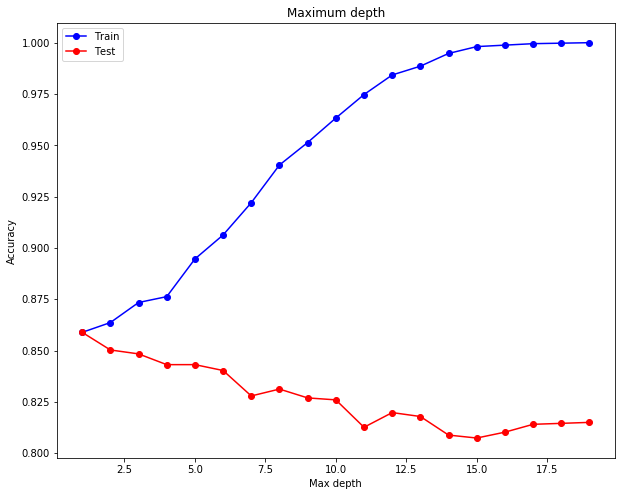

In [145]:
plt.figure(figsize = (10,8))
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Maximum depth')
plt.legend();

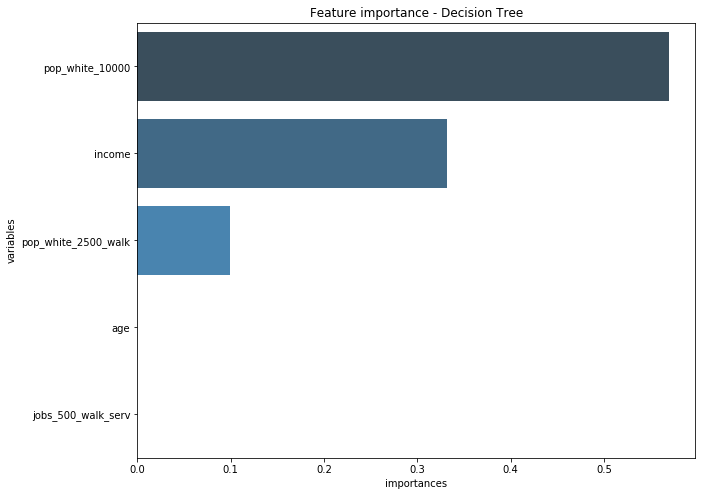

In [149]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=2)
clf.fit(X_train, y_train);

aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=aa[:5],palette="Blues_d" )
plt.title('Feature importance - Decision Tree');

In [151]:
pd.crosstab( y_test, clf.predict(X_test))#,normalize = 'index')

col_0,0.0,1.0
s_type,,
0.0,2,109
1.0,5,783


In [153]:
clf.score(X_test, y_test)

0.8731924360400445

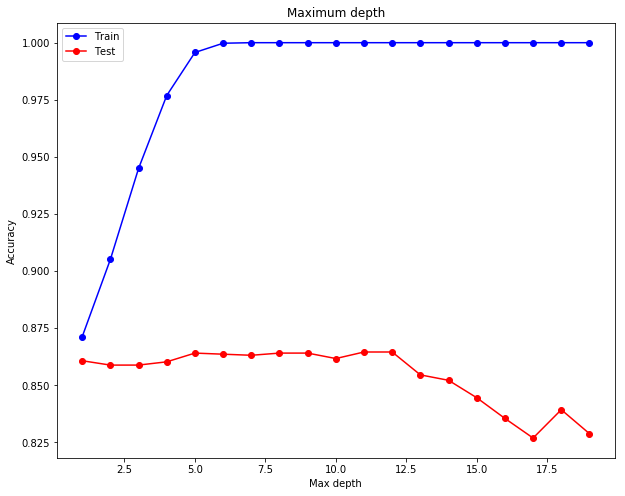

In [207]:
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = GradientBoostingClassifier(max_depth = i, n_estimators = 100)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
    
plt.figure(figsize = (10,8))
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Maximum depth')
plt.legend();

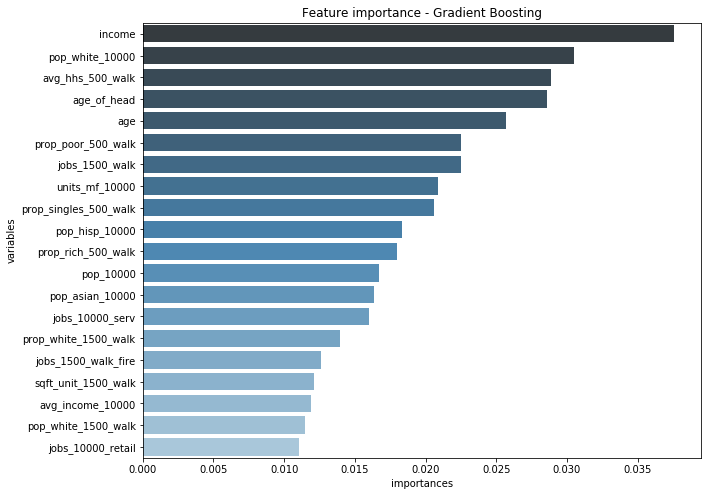

In [208]:
model = GradientBoostingClassifier(max_depth=5, n_estimators=100)
model.fit(X_train, y_train)

# importances = model.feature_importances_
# pd.crosstab( y_test, model.predict(X_test))
# model.score(X_test, y_test)

feat_importance = pd.DataFrame({'importances':model.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=feat_importance[:20],palette="Blues_d" )
plt.title('Feature importance - Gradient Boosting');

In [209]:
pd.crosstab( y_test, model.predict(X_test))

col_0,0.0,1.0
s_type,,
0.0,44,67
1.0,21,767


In [210]:
model.score(X_test, y_test)

0.9021134593993326

In [236]:
probs = model.predict_proba(X_test)
results_table = pd.DataFrame(probs, columns= ['private', 'public'])
results_table['real'] = np.array(y_test)

TPR_list = []
FPR_list = []
F1_score_list = []
for x in np.linspace(0,1,100):
    results_table['predicted'] = (results_table.public > x)*1
    results_table['tp'] = (results_table.real == 1) & (results_table.predicted == 1)
    results_table['tn'] = (results_table.real == 0) & (results_table.predicted == 0)
    results_table['fp'] = (results_table.real == 0) & (results_table.predicted == 1)
    results_table['fn'] = (results_table.real == 1) & (results_table.predicted == 0)
# print ((results_table.real == results_table.predicted).mean())
# pd.crosstab( results_table.real, results_table.predicted)
    TP = results_table.tp.sum()
    TN = results_table.tn.sum()
    FP = results_table.fp.sum()
    FN = results_table.fn.sum()

    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    recall = TPR 
    precision = TP / (TP + FP)
    F1_score = 2*(precision*recall)/(precision+recall)
    
    TPR_list.append(TPR)
    FPR_list.append(FPR)
    F1_score_list.append(F1_score)
    
# results_table

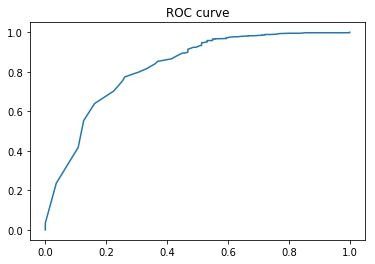

In [234]:
plt.plot(FPR_list, TPR_list)
plt.title('ROC curve');

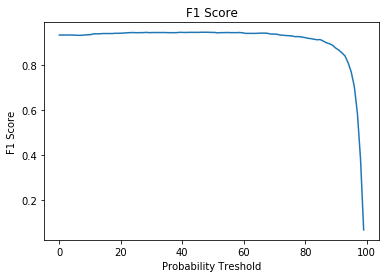

In [248]:
plt.plot( np.linspace(0,1,100)*100, F1_score_list,)
plt.xlabel('Probability Treshold');
plt.ylabel('F1 Score')
plt.title('F1 Score');

In [249]:
results_table['predicted'] = (results_table.public > 0.9)*1
results_table
pd.crosstab(results_table.predicted, results_table.real)
# results_table.groupby('real').agg({'public':['mean', 'std']})

real,0.0,1.0
predicted,,
0,74,145
1,37,643


In [ ]:
'''
Merge studnets and households tables with accesibility variables (beam and distance based)
Separate 70/30 for train and test data 
Prepare this for simulation

Step for simulation 
1. Public.Private model 
2. Public school model 
3. Private school model 
'''

In [115]:
a = orca.get_table('my_table').to_frame()
a.s_type.value_counts()

1.0    2844
0.0     443
Name: s_type, dtype: int64

In [73]:
mm.initialize()

Path not found: /configs


In [11]:
orca.add_table('my_table', students)
model = BinaryLogitStep(tables = 'my_table', model_expression = 's_type ~ np.log(income) + tenure + AGE')

NameError: name 'students' is not defined

In [146]:
model.fit()

Optimization terminated successfully.
         Current function value: 0.388920
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 s_type   No. Observations:                 3287
Model:                          Logit   Df Residuals:                     3283
Method:                           MLE   Df Model:                            3
Date:                Fri, 25 Oct 2019   Pseudo R-squ.:                 0.01629
Time:                        22:51:14   Log-Likelihood:                -1278.4
converged:                       True   LL-Null:                       -1299.6
                                        LLR p-value:                 3.394e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8944      0.261      3.421      0.001       0.382       1.407
income         0.0031      0.

## TOD Model

In [11]:
# This is a first approach to run my a 2-d estimation and random sample # 
# This is to estimate TOD for school arrival and departure time
from scipy import stats
m1 = np.random.normal(size=10000)
m2 = np.random.normal(scale=0.5, size=10000) + 56
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
kernel.resample(size = 2)

array([[-0.46764288, -0.20242127],
       [57.06977981, 56.24852572]])